In [1]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("science.mplstyle")
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}'


colors_dict = {"truth":"grey",
               "salad": "#009E73",
               "feta": "#CC79A7",
               "cathode":"#D55E00",
               "curtains":"#E69F00",
                "combined": "#e41a1c",
               "combined_scores": "#0072B2",
                "ideal_ad":"#56B4E9"}


In [2]:
# loading and understanding the data
data_path = '/global/home/users/rrmastandrea/scaled_data_wide/'

cathode_data = np.load(f"{data_path}nsig_injected_0/cathode.npy")
curtains_data = np.load(f"{data_path}nsig_injected_0/curtains.npy")
feta_data = np.load(f"{data_path}nsig_injected_0/feta_o6.npy")
salad_data = np.load(f"{data_path}nsig_injected_0/salad.npy")
salad_weights = np.load(f"{data_path}nsig_injected_0/salad_weights.npy")

truth_data = np.load(f"{data_path}nsig_injected_0/data.npy")


print("data contains: mj1, delta mj, tau21_j1, tau21_d2, deltaR, m_jj")
for data in [cathode_data, curtains_data, feta_data, salad_data, truth_data]:
    print("shape: ", data.shape)
    print("min: ", data.min(axis=0))
    print("mean: ", data.mean(axis=0))
    print("max: ", data.max(axis=0))

FileNotFoundError: [Errno 2] No such file or directory: '/global/home/users/rrmastandrea/scaled_data_wide/nsig_injected_0/cathode.npy'

Looking at these numbers, we see that we can train a **balanced** multiclass classifier of CATHODE vs CURTAINS vs FETA vs SALAD  using 400k events of each method. We evaluate on the 120k truth events in the end. 

For training, a train / test / val split of 60/20/20 would mean 240k train, 80k test, and 80k val events. 

Before training the classifier, let's have a look at a few histograms in physical space.

In [ ]:
# from https://github.com/rmastand/FETA/blob/ee4942e668b94df7b504b1503b027bdc28827eb1/helpers/datasets.py#L227

# standardization transformation and its inverse:
def minmaxscale(data, col_minmax, lower = -3.0, upper = 3.0, forward = True):
    if forward:    
        minmaxscaled_data = np.zeros(data.shape)
        for col in range(data.shape[1]):
            X_std = (data[:, col] - col_minmax[col][0]) / (col_minmax[col][1] - col_minmax[col][0])
            minmaxscaled_data[:, col] = X_std * (upper - lower) + lower      
        return minmaxscaled_data

    else:  
        reversescaled_data = np.zeros(data.shape)
        for col in range(data.shape[1]):
            X_std = (data[:, col] - lower) / (upper - lower)
            reversescaled_data[:, col] = X_std * (col_minmax[col][1] - col_minmax[col][0]) + col_minmax[col][0]
        return reversescaled_data
    


In [ ]:
# load minmax and transform data to physical space

col_minmax = np.load(f"{data_path}col_minmax.npy")
cathode_physical = minmaxscale(cathode_data, col_minmax, lower=0, upper=1, forward=False)
curtains_physical = minmaxscale(curtains_data, col_minmax, lower=0, upper=1, forward=False)
feta_physical = minmaxscale(feta_data, col_minmax, lower=0, upper=1, forward=False)
salad_physical = minmaxscale(salad_data, col_minmax, lower=0, upper=1, forward=False)
truth_physical = minmaxscale(truth_data, col_minmax, lower=0, upper=1, forward=False)

In [ ]:
# plot them in comparison to see if transformation etc. worked correctly


bins = 40
sim_color = "#990000"
dat_color = "#1c4587"
linewidth = 2

fig, ax = plt.subplots(2, 3, figsize = (12, 8))
fig.subplots_adjust(right=0.8, left = 0.2)

title_dict = {0: f"$m_{{J1}}$ [GeV]", 1: f"$\Delta m_{{JJ}}$ [GeV]", 2: f"$\\tau_{{J1}}^{{21}}$", 
              3: f"$\\tau_{{J2}}^{{21}}$", 4: f"$\Delta R_{{JJ}}$", 5: f"$m_{{JJ}}$ [GeV]"}
kwargs = {'density': True, 'histtype': 'step', 'lw': 2., 'alpha': 0.6}
legend_loc = ['upper right', 'upper right', 'upper left', 'upper left', 'upper left', 'lower left']


for ax_x in range(2):
    for ax_y in range(3):
        i = ax_x*3 + ax_y
        ax[ax_x, ax_y].hist(salad_physical[:,i], bins = np.linspace(min(truth_physical[:,i]), max(truth_physical[:,i]), bins), density = True, label = "SALAD", 
                            histtype = "step", linewidth = linewidth, weights = salad_weights,
                           color=colors_dict['salad'])
        ax[ax_x, ax_y].hist(cathode_physical[:,i], bins =  np.linspace(min(truth_physical[:,i]), max(truth_physical[:,i]), bins), density = True, label = "CATHODE", 
                            histtype = "step",linewidth = linewidth,
                           color=colors_dict['cathode'])
        ax[ax_x, ax_y].hist(curtains_physical[:,i], bins =  np.linspace(min(truth_physical[:,i]), max(truth_physical[:,i]), bins), density = True, label = "CURTAINS", 
                            histtype = "step",  linewidth = linewidth,
                           color=colors_dict['curtains'])
        ax[ax_x, ax_y].hist(feta_physical[:,i], bins =  np.linspace(min(truth_physical[:,i]), max(truth_physical[:,i]), bins), density = True, label = "FETA", 
                            histtype = "step", linewidth = linewidth,
                           color=colors_dict['feta'])
        ax[ax_x, ax_y].hist(truth_physical[:,i], bins =  np.linspace(min(truth_physical[:,i]), max(truth_physical[:,i]), bins), density = True, label = "Truth", 
                            histtype = "stepfilled", linewidth = linewidth,
                           color=colors_dict['truth'], alpha = 0.6)
        
        
        
        ax[ax_x, ax_y].set_xlabel(title_dict[i], fontsize = 30)
        ax[ax_x, ax_y].tick_params(axis='both', which='major', labelsize=20)
        ax[ax_x, ax_y].set_yticks([])

ax[0,0].set_ylabel("Density", fontsize = 30)  
ax[1,0].set_ylabel("Density", fontsize = 30) 
ax[0,0].legend(fontsize = 19, loc = "upper right")  
#plt.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.0, -0.45), fontsize = 15)

plt.tight_layout()


dpi = 800 
#plt.subplot(2,3,5)
plt.savefig(f'plots/background_validation.pdf', facecolor='white', dpi = dpi)
plt.show()

The distributions seem to agree with fig. 4 of FETA (2212.11285).

(20,) (20,) (20,)
[[0.004448946694624034], [0.004496465659544535]]
[[0.004472663508986008], [0.0035253965751045335]]
[[0.006251824512857329], [0.005741590207589242]]
[[0.006107795010472428], [0.004331110455074949]]


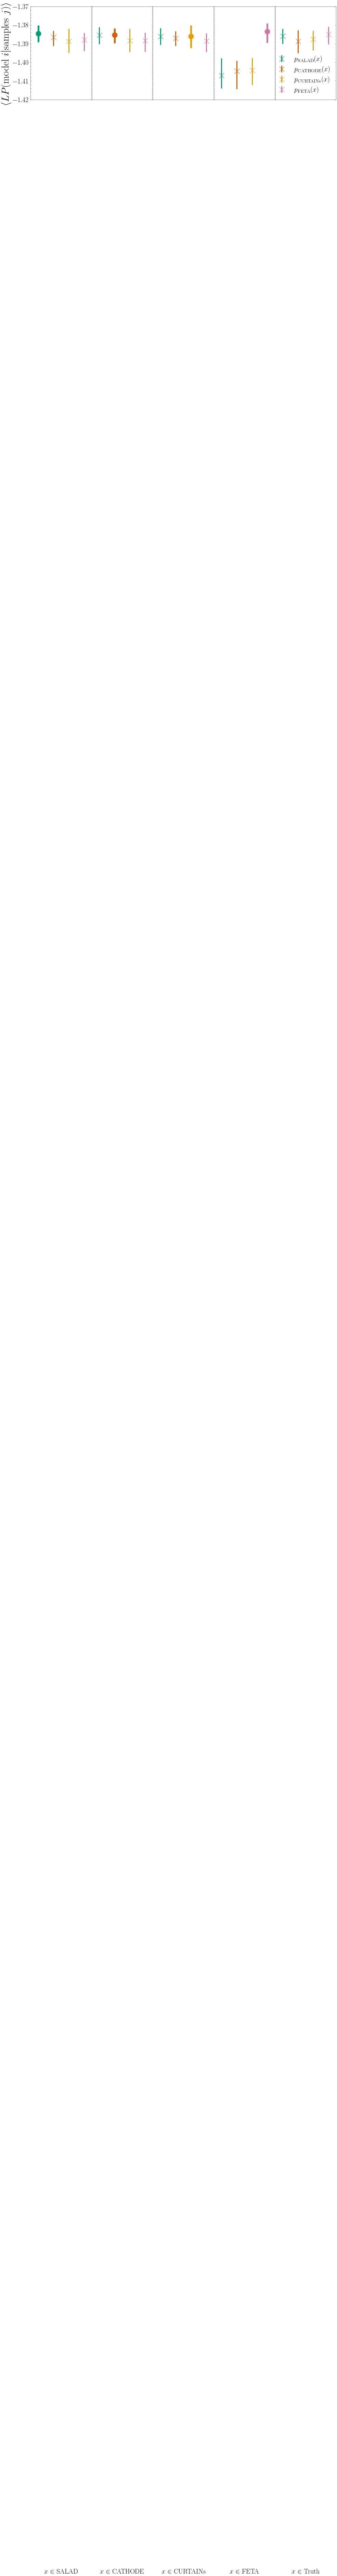

In [8]:
# plot average of the log posterior of the runs above

l = 3
f_1 = 20
f_2 = 30
alpha = 0.4
dpi = 800
ms = 12

#order = ["cathode", "curtains", "feta", "salad"]
"""
with open(f'log_posterior_mean.npy', 'rb') as f:
    to_plot_central_old = np.load(f)
with open(f'log_posterior_std.npy', 'rb') as f:
    to_plot_err_old = np.load(f)
"""
with open(f'log_posterior_med.npy', 'rb') as f:
    to_plot_median_old = np.load(f)
with open(f'log_posterior_err_lower.npy', 'rb') as f:
    to_plot_err_lower_old = np.load(f)
with open(f'log_posterior_err_higher.npy', 'rb') as f:
    to_plot_err_higher_old = np.load(f)

# reordering hell!!!
"""
to_plot_central = np.zeros(to_plot_central_old.shape)
to_plot_err = np.zeros(to_plot_err_old.shape)
to_plot_central[0] = to_plot_central_old[15]
to_plot_central[1] = to_plot_central_old[12]
to_plot_central[2] = to_plot_central_old[13]
to_plot_central[3] = to_plot_central_old[14]
to_plot_central[4] = to_plot_central_old[3]
to_plot_central[5] = to_plot_central_old[0]
to_plot_central[6] = to_plot_central_old[1]
to_plot_central[7] = to_plot_central_old[2]
to_plot_central[8] = to_plot_central_old[7]
to_plot_central[9] = to_plot_central_old[4]
to_plot_central[10] = to_plot_central_old[5]
to_plot_central[11] = to_plot_central_old[6]
to_plot_central[12] = to_plot_central_old[11]
to_plot_central[13] = to_plot_central_old[8]
to_plot_central[14] = to_plot_central_old[9]
to_plot_central[15] = to_plot_central_old[10]
to_plot_central[16] = to_plot_central_old[16]
to_plot_central[17] = to_plot_central_old[17]
to_plot_central[18] = to_plot_central_old[18]
to_plot_central[19] = to_plot_central_old[19]
to_plot_err[0] = to_plot_err_old[15]
to_plot_err[1] = to_plot_err_old[12]
to_plot_err[2] = to_plot_err_old[13]
to_plot_err[3] = to_plot_err_old[14]
to_plot_err[4] = to_plot_err_old[3]
to_plot_err[5] = to_plot_err_old[0]
to_plot_err[6] = to_plot_err_old[1]
to_plot_err[7] = to_plot_err_old[2]
to_plot_err[8] = to_plot_err_old[7]
to_plot_err[9] = to_plot_err_old[4]
to_plot_err[10] = to_plot_err_old[5]
to_plot_err[11] = to_plot_err_old[6]
to_plot_err[12] = to_plot_err_old[11]
to_plot_err[13] = to_plot_err_old[8]
to_plot_err[14] = to_plot_err_old[9]
to_plot_err[15] = to_plot_err_old[10]
to_plot_err[16] = to_plot_err_old[16]
to_plot_err[17] = to_plot_err_old[17]
to_plot_err[18] = to_plot_err_old[18]
to_plot_err[19] = to_plot_err_old[19]
"""

to_plot_median = np.zeros(to_plot_median_old.shape)
to_plot_err_lower = np.zeros(to_plot_err_lower_old.shape)
to_plot_err_higher = np.zeros(to_plot_err_higher_old.shape)

print(to_plot_median.shape,to_plot_err_lower.shape, to_plot_err_higher.shape )

to_plot_median[0] = to_plot_median_old[15]
to_plot_median[1] = to_plot_median_old[12]
to_plot_median[2] = to_plot_median_old[13]
to_plot_median[3] = to_plot_median_old[14]
to_plot_median[4] = to_plot_median_old[3]
to_plot_median[5] = to_plot_median_old[0]
to_plot_median[6] = to_plot_median_old[1]
to_plot_median[7] = to_plot_median_old[2]
to_plot_median[8] = to_plot_median_old[7]
to_plot_median[9] = to_plot_median_old[4]
to_plot_median[10] = to_plot_median_old[5]
to_plot_median[11] = to_plot_median_old[6]
to_plot_median[12] = to_plot_median_old[11]
to_plot_median[13] = to_plot_median_old[8]
to_plot_median[14] = to_plot_median_old[9]
to_plot_median[15] = to_plot_median_old[10]
to_plot_median[16] = to_plot_median_old[16]
to_plot_median[17] = to_plot_median_old[17]
to_plot_median[18] = to_plot_median_old[18]
to_plot_median[19] = to_plot_median_old[19]
to_plot_err_lower[0] = to_plot_err_lower_old[15]
to_plot_err_lower[1] = to_plot_err_lower_old[12]
to_plot_err_lower[2] = to_plot_err_lower_old[13]
to_plot_err_lower[3] = to_plot_err_lower_old[14]
to_plot_err_lower[4] = to_plot_err_lower_old[3]
to_plot_err_lower[5] = to_plot_err_lower_old[0]
to_plot_err_lower[6] = to_plot_err_lower_old[1]
to_plot_err_lower[7] = to_plot_err_lower_old[2]
to_plot_err_lower[8] = to_plot_err_lower_old[7]
to_plot_err_lower[9] = to_plot_err_lower_old[4]
to_plot_err_lower[10] = to_plot_err_lower_old[5]
to_plot_err_lower[11] = to_plot_err_lower_old[6]
to_plot_err_lower[12] = to_plot_err_lower_old[11]
to_plot_err_lower[13] = to_plot_err_lower_old[8]
to_plot_err_lower[14] = to_plot_err_lower_old[9]
to_plot_err_lower[15] = to_plot_err_lower_old[10]
to_plot_err_lower[16] = to_plot_err_lower_old[16]
to_plot_err_lower[17] = to_plot_err_lower_old[17]
to_plot_err_lower[18] = to_plot_err_lower_old[18]
to_plot_err_lower[19] = to_plot_err_lower_old[19]
to_plot_err_higher[0] = to_plot_err_higher_old[15]
to_plot_err_higher[1] = to_plot_err_higher_old[12]
to_plot_err_higher[2] = to_plot_err_higher_old[13]
to_plot_err_higher[3] = to_plot_err_higher_old[14]
to_plot_err_higher[4] = to_plot_err_higher_old[3]
to_plot_err_higher[5] = to_plot_err_higher_old[0]
to_plot_err_higher[6] = to_plot_err_higher_old[1]
to_plot_err_higher[7] = to_plot_err_higher_old[2]
to_plot_err_higher[8] = to_plot_err_higher_old[7]
to_plot_err_higher[9] = to_plot_err_higher_old[4]
to_plot_err_higher[10] = to_plot_err_higher_old[5]
to_plot_err_higher[11] = to_plot_err_higher_old[6]
to_plot_err_higher[12] = to_plot_err_higher_old[11]
to_plot_err_higher[13] = to_plot_err_higher_old[8]
to_plot_err_higher[14] = to_plot_err_higher_old[9]
to_plot_err_higher[15] = to_plot_err_higher_old[10]
to_plot_err_higher[16] = to_plot_err_higher_old[16]
to_plot_err_higher[17] = to_plot_err_higher_old[17]
to_plot_err_higher[18] = to_plot_err_higher_old[18]
to_plot_err_higher[19] = to_plot_err_higher_old[19]


ymin, ymax = -1.42, -1.37


# reorder
order = [  "salad", "cathode", "curtains", "feta"]



fig = plt.figure(figsize = (16, 5)) 

to_bold = [0, 5, 10, 15]
legends = [ '$p_{\mathrm{SALAD}}(x)$','$p_{\mathrm{CATHODE}}(x)$', '$p_{\mathrm{CURTAINs}}(x)$','$p_{\mathrm{FETA}}(x)$',]
for i in range(20):
    
    if i in to_bold:
        
        print([[to_plot_median[i]-to_plot_err_lower[i]],[to_plot_err_higher[i]-to_plot_median[i]]])

        plt.errorbar(i, to_plot_median[i], [[to_plot_median[i]-to_plot_err_lower[i]],[to_plot_err_higher[i]-to_plot_median[i]]], fmt='o', color = colors_dict[order[i%4]],
                     elinewidth=5, markersize = 15 )
    elif i >= 16:
        plt.errorbar(i, to_plot_median[i],yerr = [[to_plot_median[i]-to_plot_err_lower[i]],[to_plot_err_higher[i]-to_plot_median[i]]], fmt='x', color = colors_dict[order[i%4]], 
                     elinewidth=3, markersize = 15, label = legends[i-16] )

    else:
        plt.errorbar(i, to_plot_median[i], yerr = [[to_plot_median[i]-to_plot_err_lower[i]],[to_plot_err_higher[i]-to_plot_median[i]]], fmt='x', color = colors_dict[order[i%4]], 
                     elinewidth=3, markersize = 15)

    
plt.vlines([3.5, 7.5, 11.5, 15.5], ymin, ymax, ls='dashed', color='k')
plt.ylim((ymin, ymax))
plt.xlim((-0.5, 19.5))
plt.xticks([])
plt.yticks(fontsize = f_1)
plt.ylim(-1.42, -1.37)

plt.ylabel('$\\langle LP(\\text{model } i|\\text{samples } j) \\rangle$', fontsize = f_2)


plt.text(1.5,ymax + .003, '$x \in$ SALAD', ha='center', fontsize = f_1)
plt.text(5.5, ymax + .003, '$x \in$ CATHODE', ha='center', fontsize = f_1)
plt.text(9.5, ymax + .003, '$x \in$ CURTAINs', ha='center', fontsize = f_1)
plt.text(13.5, ymax + .003, '$x \in$ FETA', ha='center', fontsize = f_1)
plt.text(17.5, ymax + .003, '$x \in$ Truth', ha='center', fontsize = f_1)

plt.legend(fontsize = f_1, loc = "lower right")


fig.savefig(f"plots/discrim_methods.pdf", dpi = dpi)

plt.show()


